# Optimizing the Data Processing

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/tutorials/experts/en/dataset/mindspore_optimize.ipynb)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/experts/source_en/dataset/optimize.ipynb)

Data is the most important part of the whole deep learning, because the quality of the data determines the upper limit of the final result, and the quality of the model is only to infinitely approach this upper limit, so high-quality data input will play a positive role in the entire deep neural network. The data in the entire process of data processing and data augmentation is like water through the pipeline, continuous flows to the training system, as shown in the figure:

![pipeline](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/pipeline.png)

MindSpore provides data processing and data augmentation functions for users. In the pipeline process, if each step can be properly used, the data performance will be greatly improved.

This section describes how to optimize performance during data loading, data processing, and data augmentation based on the CIFAR-10 dataset.

In addition, the storage, architecture and computing resources of the operating system will influence the performance of data processing to a certain extent.

## Downloading the Dataset

Run the following command to obtain the dataset.

Download the CIFAR-10 binary format dataset and extract the dataset file to the `./datasets/` directory, which is used when the data is loaded.

In [1]:
from mindvision import dataset
import os
import shutil

dl_path = "./datasets"
data_dir = "./datasets/cifar-10-batches-bin/"
dl_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

dl = dataset.DownLoad()  # Download CIFAR-10 dataset
dl.download_and_extract_archive(url=dl_url, download_path=dl_path)
test_path = "./datasets/cifar-10-batches-bin/test"
train_path = "./datasets/cifar-10-batches-bin/train"
os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
if not os.path.exists(os.path.join(test_path, "test_batch.bin")):
    shutil.move("./datasets/cifar-10-batches-bin/test_batch.bin", test_path)
[shutil.move("./datasets/cifar-10-batches-bin/"+i, train_path) for i in os.listdir("./datasets/cifar-10-batches-bin/") if os.path.isfile("./datasets/cifar-10-batches-bin/"+i) and not i.endswith(".html") and not os.path.exists(os.path.join(train_path, i))]

The directory structure of the decompressed dataset file is as follows:

```text
./datasets/cifar-10-batches-bin
├── readme.html
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin
```

## Optimizing the Data Loading Performance

MindSpore supports loading common datasets in fields such as computer vision, natural language processing, datasets in specific formats, and user-defined datasets. The underlying implementation of different dataset loading interfaces is different, and the performance is also different, as follows:

|      | Common Dataset | User-defined Dataset | MindRecord Dataset |
| :----: | :----: | :----: | :----: |
| Underlying implementation | C++ | Python | C++ |
| Performance | High | Medium | High |

Performance Optimization Solution

![data-loading-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/data_loading_performance_scheme.png)

Suggestions on data loading performance optimization are as follows:

- For commonly used datasets that have already provided loading interfaces, it is preferential to use the dataset loading interface provided by MindSpore to load, which can obtain better loading performance. For details, see [Built-in Loading Operations](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html), if the performance cannot meet the requirements, use the multi-thread concurrency solution. For details, see [Multi-thread Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-thread-optimization-solution).
- For a dataset format that is not supported, it is recommended to convert the dataset to the MindRecord data format before loading it using the `MindDataset` class (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.MindDataset.html) for detailed use). For detailed contents, please refer to [Converting Dataset to MindRecord](https://www.mindspore.cn/tutorials/en/master/advanced/dataset/record.html). If the performance cannot meet the requirements, use the multi-thread concurrency solution, for details, see [Multi-thread Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-thread-optimization-solution).
- For dataset formats that are not supported, the user-defined `GeneratorDataset` class is preferred for implementing fast algorithm verification (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.GeneratorDataset.html) for detailed use). If the performance cannot meet the requirements, the multi-process concurrency solution can be used. For details, see [Multi-process Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-process-optimization-solution).

Based on the preceding suggestions of data loading performance optimization, this experience uses the built-in load operation `Cifar10Dataset` class (Please refer to the [API](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html) for detailed use), the `MindDataset` class after data conversion, and uses the `GeneratorDataset` class to load data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in operations to load the CIFAR-10 dataset in binary format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [5]:
import mindspore.dataset as ds
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[209, 206, 192],
  [211, 209, 201],
  [221, 217, 213],
  ...
  [172, 175, 194],
  [169, 173, 190],
  [115, 121, 145]],
 [[226, 230, 211],
  [227, 229, 218],
  [230, 232, 221],
  ...
  [153, 153, 171],
  [156, 156, 173],
  [106, 111, 129]],
 [[214, 226, 203],
  [214, 222, 204],
  [217, 227, 206],
  ...
  [167, 166, 176],
  [147, 147, 156],
  [ 78,  84,  96]],
 ...
 [[ 40,  69,  61],
  [ 37,  63,  57],
  [ 43,  68,  66],
  ...
  [ 55,  70,  69],
  [ 40,  54,  51],
  [ 27,  44,  36]],
 [[ 33,  61,  50],
  [ 37,  65,  56],
  [ 54,  72,  74],
  ...
  [ 47,  60,  56],
  [ 58,  66,  64],
  [ 36,  50,  46]],
 [[ 29,  41,  37],
  [ 38,  60,  59],
  [ 51,  76,  81],
  ...
  [ 32,  51,  43],
  [ 47,  61,  54],
  [ 56,  67,  66]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 5)}


2. Use the `Cifar10ToMR` class to convert the CIFAR-10 dataset into the MindSpore data format. In this example, the CIFAR-10 dataset in Python file format is used. Then use the `MindDataset` class to load the dataset in the MindSpore data format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for data and a data record is read through the iterator.

In [6]:
from mindspore.mindrecord import Cifar10ToMR

trans_path = "./transform/"

if not os.path.exists(trans_path):
    os.mkdir(trans_path)

os.system("rm -f {}cifar10*".format(trans_path))

# download CIFAR-10 python
py_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-python.tar.gz"
dl.download_and_extract_archive(url=py_url, download_path=dl_path)

cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path, cifar10_mindrecord_path)
# execute transformation from CIFAR-10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_files=cifar10_mindrecord_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator()))

{'data': Tensor(shape=[1283], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
 107, 249,  17,  58, 213, 185, 117, 181, 143, 255, 217]), 'id': Tensor(shape=[], dtype=Int64, value= 32476), 'label': Tensor(shape=[], dtype=Int64, value= 9)}


3. The `GeneratorDataset` class is used to load the user-defined dataset, and the multi-process optimization solution is used. Four processes are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data, and a data record is read through the iterator.

In [7]:
import numpy as np
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create a GeneratorDataset object for reading data
dataset = ds.GeneratorDataset(source=generator_func(5), column_names=["data"], num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## Optimizing the Shuffle Performance

The shuffle operation is used to shuffle ordered datasets or repeated datasets. MindSpore provides the `shuffle` function for users.  A larger value of `buffer_size` indicates a higher shuffling degree, consuming more time and computing resources. This API allows users to shuffle the data at any time during the entire pipeline process. For the detailed contents, refer to [shuffle processing](https://mindspore.cn/tutorials/zh-CN/master/beginner/dataset.html#shuffle). Because the underlying implementation methods are different, the performance of this method is not as good as that of setting the `shuffle` parameter to directly shuffle data by referring to the [Built-in Loading Operations](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html).

Performance Optimization Solution

![shuffle-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/shuffle_performance_scheme.png)

Suggestions on shuffle performance optimization are as follows:

- Use the `shuffle` parameter of built-in loading operations to shuffle data.
- If the `shuffle` function is used and the performance still cannot meet the requirements, adjust the value of the `buffer_size` parameter to improve the performance.

Based on the preceding shuffle performance optimization suggestions, the `shuffle` parameter of the `Cifar10Dataset` class of built-in loading operations and the `Shuffle` function are used to shuffle data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in operations to load the CIFAR-10 dataset. In this example, the CIFAR-10 dataset in binary format is used, and the `shuffle` parameter is set to True to perform data shuffle. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [8]:
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[119, 193, 196],
  [121, 192, 204],
  [123, 193, 209],
  ...
  [110, 168, 177],
  [109, 167, 176],
  [110, 168, 178]],
 [[110, 188, 199],
  [109, 185, 202],
  [111, 186, 204],
  ...
  [107, 173, 179],
  [107, 173, 179],
  [109, 175, 182]],
 [[110, 186, 200],
  [108, 183, 199],
  [110, 184, 199],
  ...
  [115, 183, 189],
  [117, 185, 190],
  [117, 185, 191]],
 ...
 [[210, 253, 250],
  [212, 251, 250],
  [214, 250, 249],
  ...
  [194, 247, 247],
  [190, 246, 245],
  [184, 245, 244]],
 [[215, 253, 251],
  [218, 252, 250],
  [220, 251, 249],
  ...
  [200, 248, 248],
  [195, 247, 245],
  [189, 245, 244]],
 [[216, 253, 253],
  [222, 251, 250],
  [225, 250, 249],
  ...
  [204, 249, 248],
  [200, 246, 244],
  [196, 245, 244]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 0)}


2. Use the `shuffle` function to shuffle data. Set `buffer_size` to 3 and use the `GeneratorDataset` class to generate data.

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[0 1 2 3 4]
[1 2 3 4 5]
[4 5 6 7 8]
[3 4 5 6 7]


## Optimizing the Data Augmentation Performance

During image classification training, especially when the dataset is small, users can use data augmentation to preprocess images to enrich the dataset. MindSpore provides multiple data augmentation methods, including:

- Use data augmentation operations implemented in C++ (mainly based on OpenCV).
- Use data augmentation operations implemented in Python (mainly based on Pillow).
- Users can define Python functions as needed to perform data augmentation.

Please refer to [Data Augmentation](https://www.mindspore.cn/tutorials/experts/en/master/dataset/augment.html). The performance varies according to the underlying implementation methods. This is shown below:

| Programming Language | Third Party Library | Description |
| :----: | :----: | :----: |
| C++ | OpenCV | Implemented in C++ code which has higher performance |
| Python | Pillow | Implemented in Python code which is more flexible |

Performance Optimization Solution

![data-enhancement-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/data_enhancement_performance_scheme.png)

Suggestions on data augmentation performance optimization are as follows:

- The C++ implemented operations are preferentially used to perform data augmentation for its higher performance. If the performance cannot meet the requirements, refer to [Multi-thread Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-thread-optimization-solution), [Compose Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#compose-optimization-solution), or [Operation Fusion Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#operation-fusion-optimization-solution).
- If the Python implemented operations are used to perform data augmentation and the performance still cannot meet the requirements, refer to [Multi-thread Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-thread-optimization-solution), [Multi-process Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-process-optimization-solution), [Compose Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#compose-optimization-solution), or [Operation Fusion Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#operation-fusion-optimization-solution).
- If the user-defined Python functions are used to perform data augmentation and the performance still cannot meet the requirements, use the [Multi-thread Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-thread-optimization-solution) or [Multi-process Optimization Solution](https://www.mindspore.cn/tutorials/experts/en/master/dataset/optimize.html#multi-process-optimization-solution). If the performance still cannot be improved, in this case, optimize the user-defined Python code.

MindSpore also supports users to use the data augmentation operations implemented in C++ and Python at the same time, but due to the different underlying implementations of the two, excessive mixing will increase resource overhead and reduce processing performance. It is recommended that users should use the operations implemented in the same language, or use one of them first, then use the other. Please do not switch frequently between the data augmentation operations of two different implementation languages.

Based on the preceding suggestions of data augmentation performance optimization, the C++ implemented operations and user-defined Python functions are used to perform data augmentation. The code is displayed as follows:

1. The C++ implemented operations are used to perform data augmentation. During data augmentation, the multi-thread optimization solution is used. Four threads are enabled to concurrently complete the task. The operation fusion optimization solution is used and the `RandomResizedCrop` fusion class is used to replace the `RandomResize` and `RandomCrop` classes.

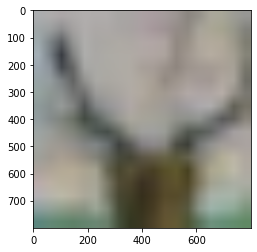

In [10]:
import mindspore.dataset.vision as vision
import matplotlib.pyplot as plt

cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
transforms = vision.RandomResizedCrop((800, 800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms, input_columns="image", num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. A user-defined Python function is used to perform data augmentation. During data augmentation, the multi-process optimization solution is used, and four processes are enabled to concurrently complete the task.

In [11]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

func = lambda x: x**2
ds4 = ds3.map(operations=func, input_columns="data", python_multiprocessing=True, num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## Optimizing the Operating System Performance

Data processing is performed on the Host. Therefore, configurations of the running environment may affect the processing performance.  Major factors include storage, NUMA architecture, and CPU (computing resources).

1. Storage

The data loading process involves frequent disk operations, and the performance of disk reading and writing directly affects the speed of data loading. Solid State Drive (SSD) is recommended for storing large datasets when the dataset is large. SSDs generally have higher read and write speeds than ordinary disks, reducing the impact of I/O operations on data processing performance.

In general, the loaded data will be cached into the operating system's page cache, which reduces the overhead of subsequent reads to a certain extent and accelerates the data loading speed of subsequent Epochs. Users can also manually cache the augmented data through the single-node caching technology provided by MindSpore, avoiding duplicate data loading and data augmentation.

2. NUMA architecture

NUMA, Non-Uniform Memory Access, is a memory architecture that was born to solve the scalability problem in the traditional symmetric multiprocessor (SMP) architecture. In traditional architectures, multiple processors share a memory bus, which is prone to problems such as insufficient bandwidth and memory conflicts.

In the NUMA architecture, processors and memory are divided into groups, each called a node, each node has a separate integrated memory controller (IMC) bus for intra-node communication, and different nodes communicate with each other through a fast path interconnect (QPI). For a node, memory within the same node is called local memory, while memory in other nodes is called external memory. The delay in accessing local memory will be less than the delay in accessing external memory.

During data processing, you can reduce the latency of memory access by binding the process to the node. In general, we can use the following command to bind the process to the node node:

```bash
numactl --cpubind=0 --membind=0 python train.py
```

3. CPU (computing resource)

Although the data processing speed can be accelerated through multi-threaded parallel technology, there is actually no guarantee that CPU computing resources will be fully utilized. If you can artificially complete the configuration of computing resources in advance, it will be able to improve the utilization of CPU computing resources to a certain extent.

- Resource allocation

In distributed training, multiple training processes are run on one device. These training processes allocate and compete for computing resources based on the policy of the operating system. When there is a large number of processes, data processing performance may deteriorate due to resource contention. In some cases, users need to manually allocate resources to avoid resource contention.

```bash
numactl --cpubind=0 python train.py
```

- CPU frequency

For energy efficiency reasons, the operating system adjusts the CPU operating frequency as needed, but lower power consumption means that computing performance is degraded and data processing is slowed down. In order to get the most out of the CPU's maximum computing power, you need to manually set the CPU's operating frequency. If it is found that the CPU operation mode of the operating system is balanced mode or energy-saving mode, you can improve the performance of data processing by adjusting it to performance mode.

```bash
cpupower frequency-set -g performance
```

## Dataset AutoTune for Dataset Pipeline

MindSpore provides a tool named Dataset AutoTune for optimizing dataset.The Dataset AutoTune can automatically tune Dataset pipelines to improve performance. The detailed usage please refer to [Dataset AutoTune for Dataset Pipeline](https://www.mindspore.cn/tutorials/experts/en/master/dataset/dataset_autotune.html).

## Enabling Heterogeneous Acceleration for Data

MindSpore provides a computing load balancing technology which can distribute the MindSpore Tensor computing to different heterogeneous hardware. On one hand, it balances the computing overhead between different hardware, on the other, it uses the advantages of heterogeneous hardware to accelerate the computing. The detailed usage please refer to [Enabling Heterogeneous Acceleration for Data](https://www.mindspore.cn/tutorials/experts/en/master/dataset/dataset_offload.html).

## Performance Optimization Solution Summary

### Multi-thread Optimization Solution

During the data pipeline process, the number of threads for related operations can be set to improve the concurrency and performance. If the user does not manually specify the num_parallel_workers parameter, each data processing operation will use 8 sub-threads for concurrent processing by default. For example:

- During data loading, the `num_parallel_workers` parameter in the built-in data loading class is used to set the number of threads.
- During data augmentation, the `num_parallel_workers` parameter in the `map` function is used to set the number of threads.
- During batch processing, the `num_parallel_workers` parameter in the `batch` function is used to set the number of threads.

For details, see [Built-in Loading Operations](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html). When using MindSpore for standalone or distributed training, the setting of the num_parallel_workers parameter should follow the following principles:

- The summary of the num_parallel_workers parameter set for each data loading and processing operation should not be greater than the maximum number of CPU cores of the machine, otherwise it will cause resource competition between each operation.
- Before setting the num_parallel_workers parameter, it is recommended to use MindSpore's Profiler (performance analysis) tool to analyze the performance of each operation in the training, and allocate more resources to the operation with pool performance, that is, set a large num_parallel_workers to balance the throughput between various operations and avoid unnecessary waiting.
- In a standalone training scenario, increasing the num_parallel_workers parameter can often directly improve processing performance, but in a distributed scenario, due to increased CPU competition, blindly increasing num_parallel_workers may lead to performance degradation. You need to try to use a compromise value.

### Multi-process Optimization Solution

During data processing, operations implemented by Python support the multi-process mode. For example:

- By default, the `GeneratorDataset` class is in multi-process mode. The `num_parallel_workers` parameter indicates the number of enabled processes. The default value is 1. For details, see [GeneratorDataset](https://www.mindspore.cn/docs/en/master/api_python/dataset/mindspore.dataset.GeneratorDataset.html).
- If the user-defined Python functions or the Python implemennted operations are used to perform data augmentation and the `python_multiprocessing` parameter of the `map` function is set to True, the `num_parallel_workers` parameter indicates the number of processes and the default value of the `python_multiprocessing` parameter is False. In this case, the `num_parallel_workers` parameter indicates the number of threads. For details, see [Built-in Loading Operations](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.html).

### Compose Optimization Solution

Map operation can receive the Tensor operation list and apply all these operations based on a specific sequence. Compared with the Map operation used by each Tensor operation, such "Fat Map operation" can achieve better performance, as shown in the following figure:

![compose](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/compose.png)

### Operation Fusion Optimization Solution

Some fusion operations are provided to aggregate the functions of two or more operations into one operation. You can configure the environment variable `export OPTIMIZE=true` to make it effective. For details, see [Augmentation Operations](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.vision). Compared with the pipelines of their components, such fusion operations provide better performance. As shown in the figure:

![operation-fusion](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/experts/source_en/dataset/images/operation_fusion.png)

### Operating System Optimization Solution

- Use Solid State Drives to store the data.
- Bind the process to a NUMA node.

    In the multi card training scenario, each training process can be bound to different NUMA nodes by configuring environment variables `export DATASET_ENABLE_NUMA=True` to ensure more stable data processing of different training processes.

- Manually allocate more computing resources.
- Set a higher CPU frequency.